# Final Project Phase 1

### Josh Gaughan

### September 20th, 2025

In [3]:
import nflreadpy as nfl
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa

# Data Access

#### Defining team, season, and schedule variables

In [ ]:
team = "IND"
season = 2025

sched = nfl.load_schedules([season]).to_pandas()

Downloading: 2.10MB [00:00, 2.62MB/s]                          


#### Filtering to find the Colts' week 1 game

In [ ]:
colts_g1 = sched[
    (sched['game_type'] == "REG") &
    (sched['season'] == season) &
    ((sched['home_team'] == team) | (sched['away_team'] == team))
].sort_values(by=['gameday', 'week']).iloc[0]

assert not colts_g1.empty, "No game found for the specified team and season."

#### Assigning Colts week 1 game attributes to new variables

In [ ]:
game_id = colts_g1['game_id']
week = colts_g1['week']
gameday = colts_g1['gameday']
home_tm = colts_g1['home_team']
away_tm = colts_g1['away_team']
opp = away_tm if home_tm == team else home_tm

print(f"Found Colts Week {week} ({gameday}): {away_tm} @ {home_tm} | game_id = {game_id}")

Found Colts Week 1 (2025-09-07): MIA @ IND | game_id = 2025_01_MIA_IND


#### Pulling play-by-play data for this specific game

In [ ]:
pbp_g1 = nfl.load_pbp(seasons=season).to_pandas()
pbp_g1 = pbp_g1[pbp_g1['game_id'] == game_id]

Downloading: 100%|██████████| 2.59M/2.59M [00:00<00:00, 5.45MB/s]


#### Pulling roster data for this specific game

In [ ]:
rw_g1 = nfl.load_rosters_weekly(seasons = [season]).to_pandas()
rw_g1 = rw_g1[
    (rw_g1['week'] == week) &
    (rw_g1['team'].isin([team, opp]))
]

Downloading: 100%|██████████| 715k/715k [00:00<00:00, 32.5MB/s]


#### Pulling official data for this specific game

In [ ]:
officials_g1 = nfl.load_officials(seasons=season).to_pandas()
officials_g1 = officials_g1[officials_g1['game_id'] == game_id]

Downloading: 100%|██████████| 137k/137k [00:00<?, ?B/s]


#### Pulling player data

In [ ]:
players_master = nfl.load_players().to_pandas()
players_master.columns = players_master.columns.str.replace('.', '_', regex=False)
players_master.columns = players_master.columns.str.lower()
print("Players master data loaded.")

Downloading: 100%|██████████| 3.30M/3.30M [00:00<00:00, 13.5MB/s]


Players master data loaded.


# Integrity Checks

#### Showing the dimensions of each data frame

In [46]:
print("\n--- STRUCTURE ---\n")
print(f"PBP rows/cols: {pbp_g1.shape[0]} {pbp_g1.shape[1]}")
print(f"Weekly roster rows/cols: {rw_g1.shape[0]} {rw_g1.shape[1]}")
print(f"Officials rows/cols: {officials_g1.shape[0]} {officials_g1.shape[1]}\n")


--- STRUCTURE ---

PBP rows/cols: 152 376
Weekly roster rows/cols: 201 36
Officials rows/cols: 0 9



#### Checking for duplicates in play-by-play

In [ ]:
dup_plays = pbp_g1.groupby(['game_id', 'play_id']).size().reset_index(name='n')
dup_plays = dup_plays[dup_plays['n'] > 1]
if not dup_plays.empty:
    warnings.warn("Duplicate plays detected in (game_id, play_id). Inspect `dup_plays`.")
else:
    print("Key check passed: (game_id, play_id) appear unique for this game.\n")


Key check passed: (game_id, play_id) appear unique for this game.



#### Checking for duplicates in roster


In [ ]:
dup_roster = rw_g1.groupby(['team', 'gsis_id', 'week']).size().reset_index(name='n')
dup_roster = dup_roster[dup_roster['n'] > 1]
if not dup_roster.empty:
    print("Note: roster has repeated (team, gsis_id, week) rows—can be normal when multiple rows exist per role/slot.")


#### Checking to see if players are present in players_master


In [19]:
if 'gsis_id' in rw_g1.columns and 'gsis_id' in players_master.columns:
    roster_master_match = rw_g1['gsis_id'].isin(players_master['gsis_id']).mean()
    print(f"Player master match rate (weekly roster -> master by gsis_id): {round(roster_master_match * 100, 1)} %")
else:
    print("gsis_id not present to check roster->player master referential integrity.")


Player master match rate (weekly roster -> master by gsis_id): 90.0 %


#### Checking for missing data


In [ ]:
def na_rate(series):
    return series.isnull().mean()

na_summary = pd.DataFrame({
    'na_epa': [na_rate(pbp_g1['epa'])],
    'na_success': [na_rate(pbp_g1['success'])],
    'na_posteam': [na_rate(pbp_g1['posteam'])],
    'na_defteam': [na_rate(pbp_g1['defteam'])],
    'na_yardline_100': [na_rate(pbp_g1['yardline_100'])],
    'na_down': [na_rate(pbp_g1['down'])],
    'na_ydstogo': [na_rate(pbp_g1['ydstogo'])],
    'na_play_type': [na_rate(pbp_g1['play_type'])]
})
print("\n--- MISSINGNESS (PBP) ---\n")
print(na_summary)



--- MISSINGNESS (PBP) ---

     na_epa  na_success  na_posteam  na_defteam  na_yardline_100   na_down  \
0  0.013158    0.013158    0.065789    0.065789         0.078947  0.171053   

   na_ydstogo  na_play_type  
0         0.0      0.032895  


#### Checking to see if any yardline_100 is not in [0,100]


In [ ]:
bad_yardline = pbp_g1[pbp_g1['yardline_100'].notna() & ((pbp_g1['yardline_100'] < 0) | (pbp_g1['yardline_100'] > 100))]
if not bad_yardline.empty:
    warnings.warn("Out-of-range yardline_100 values observed.")

#### Checking to see if any downs are not in [1,4]


In [ ]:
bad_down = pbp_g1[pbp_g1['down'].notna() & (~pbp_g1['down'].isin(range(1, 5)))]
if not bad_down.empty:
    warnings.warn("Unexpected down values outside 1–4.")

#### Checking to see if any ydstogo are <= 0

In [ ]:
bad_ydstogo = pbp_g1[pbp_g1['ydstogo'].notna() & (pbp_g1['ydstogo'] <= 0)]
if not bad_ydstogo.empty:
    print("Non-positive ydstogo rows exist (could be goal-to-go anomalies or data glitches).")

Non-positive ydstogo rows exist (could be goal-to-go anomalies or data glitches).


#### Checking for consistency in game_id

In [47]:
if pbp_g1['game_id'].nunique() != 1:
    warnings.warn("Multiple game_ids in pbp_g1; filter may be off.")

#### Checking to see if posteam/defteam are correct


In [ ]:
valid_teams = [team, opp]
weird_teams = pbp_g1[pbp_g1['posteam'].notna() & (~pbp_g1['posteam'].isin(valid_teams))]['posteam'].unique()
if len(weird_teams) > 0:
    warnings.warn(f"Found posteam not matching Colts or opponent: check {weird_teams}")

#### Checking team abbreviations


In [ ]:
print("\n--- TEAM ABBREVS IN PBP ---\n")
print(sorted(pbp_g1['posteam'].dropna().unique()))
print(sorted(pbp_g1['defteam'].dropna().unique()))


--- TEAM ABBREVS IN PBP ---

['IND', 'MIA']
['IND', 'MIA']


# EDA and Visualizations

#### Create a points_scored column in pbp_g1

In [ ]:
pbp_g1['points_scored'] = np.select(
    [
        pbp_g1['touchdown'] == 1,
        pbp_g1['field_goal_result'] == "made",
        pbp_g1['safety'] == 1,
        pbp_g1['extra_point_result'] == "good",
        (pbp_g1['two_point_attempt'] == 1) & (pbp_g1['two_point_conv_result'] == "success")
    ],
    [6, 3, 2, 1, 2],
    default=0
)

#### Produce a table with home/away team scoring and play amounts by quarter

In [ ]:
score_by_q = pbp_g1[pbp_g1['qtr'].notna() & pbp_g1['qtr'].isin(range(1, 5))].groupby('qtr').agg(
    ind_points=pd.NamedAgg(column='points_scored', aggfunc=lambda x: np.sum(x[pbp_g1.loc[x.index, 'posteam'] == "IND"])),
    opp_points=pd.NamedAgg(column='points_scored', aggfunc=lambda x: np.sum(x[pbp_g1.loc[x.index, 'posteam'] == opp])),
    plays=pd.NamedAgg(column='play_id', aggfunc='count')
).reset_index()

print("\n--- SCORE BY QUARTER (derived from PBP points events) ---\n")
print(score_by_q)


--- SCORE BY QUARTER (derived from PBP points events) ---

   qtr  ind_points  opp_points  plays
0  1.0           3           0     31
1  2.0          17           0     45
2  3.0           3           0     33
3  4.0          10           8     43


#### Produce a table of average time per play for each team

In [ ]:
tempo = pbp_g1[pbp_g1['posteam'].notna() & pbp_g1['game_seconds_remaining'].notna()] \
    .sort_values(by='game_seconds_remaining', ascending=False) \
    .copy()
tempo['sec_between'] = tempo.groupby('posteam')['game_seconds_remaining'].diff(periods=-1)
tempo = tempo.groupby('posteam').agg(
    sec_per_play=pd.NamedAgg(column='sec_between', aggfunc=lambda x: np.median(x.dropna()))
).reset_index()

print("\n--- TEMPO (median sec/play) ---\n")
print(tempo)


--- TEMPO (median sec/play) ---

  posteam  sec_per_play
0     IND          38.5
1     MIA          34.5


#### Produce a table with various offensive efficiency stats for each team

In [ ]:
pbp_g1['play_family'] = pbp_g1['play_type'].map({
    "run": "Run",
    "pass": "Pass",
    "qb_kneel": "Clock",
    "qb_spike": "Clock",
    "no_play": "Other",
    "timeout": "Other"
}).fillna("Other")

off_mix = pbp_g1[pbp_g1['posteam'].notna()].groupby(['posteam', 'play_family']).agg(
    plays=('play_id', 'count'),
    epa_per_play=('epa', 'mean'),
    success_rate=('success', 'mean'),
    yards_per_play=('yards_gained', 'mean')
).reset_index()

off_mix['share'] = off_mix['plays'] / len(pbp_g1)
off_mix = off_mix.sort_values(by=['posteam', 'plays'], ascending=[True, False]).reset_index(drop=True)

print("\n--- OFFENSIVE MIX & EFFICIENCY ---\n")
print(off_mix)


--- OFFENSIVE MIX & EFFICIENCY ---

  posteam play_family  plays  epa_per_play  success_rate  yards_per_play  \
0     IND         Run     40      0.138052      0.500000        3.900000   
1     IND        Pass     30      0.433257      0.566667        8.733333   
2     IND       Other     15      0.189872      0.666667        0.000000   
3     MIA        Pass     35     -0.461216      0.371429        3.857143   
4     MIA         Run     12      0.339320      0.583333        6.500000   
5     MIA       Other     10      0.352272      0.777778        0.000000   

      share  
0  0.263158  
1  0.197368  
2  0.098684  
3  0.230263  
4  0.078947  
5  0.065789  


#### Produce a plot of EPA per play distribution for both teams

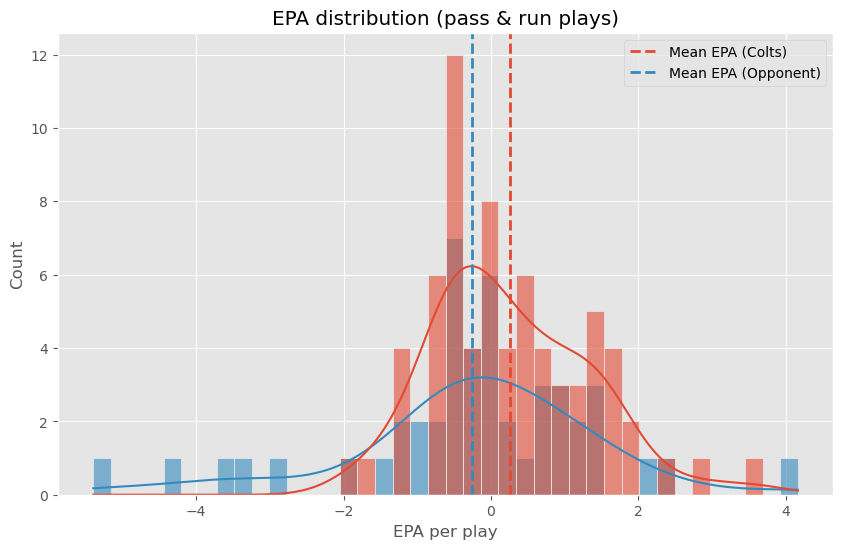

In [ ]:
# Set a style for the plots, similar to R's theme_minimal()
plt.style.use('ggplot')

epa_dist = pbp_g1[
    pbp_g1['posteam'].notna() &
    pbp_g1['play_type'].isin(["run", "pass"])
].copy()
epa_dist['is_colts'] = np.where(epa_dist['posteam'] == "IND", "Colts", "Opponent")

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=epa_dist,
    x='epa',
    hue='is_colts',
    bins=40,
    alpha=0.6,
    kde=True, # Added a kernel density estimate for smoothing
    ax=ax
)

# Add vertical lines for the mean EPA
mean_epa = epa_dist.groupby('is_colts')['epa'].mean().reset_index()
for _, row in mean_epa.iterrows():
    ax.axvline(
        row['epa'],
        color=sns.color_palette()[row.name], # Use the same color palette
        linestyle='--',
        linewidth=2,
        label=f"Mean EPA ({row['is_colts']})"
    )

ax.set_title("EPA distribution (pass & run plays)")
ax.set_xlabel("EPA per play")
ax.set_ylabel("Count")
ax.legend(title="")
plt.show()

#### Produce a plot of offensive success rate by yards to go and down

C:\Users\joshg\AppData\Local\Temp\ipykernel_104156\1227060761.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  situ = pbp_g1[pbp_g1['play_type'].isin(['pass','run'])].dropna(subset=['down','ydstogo']).groupby(


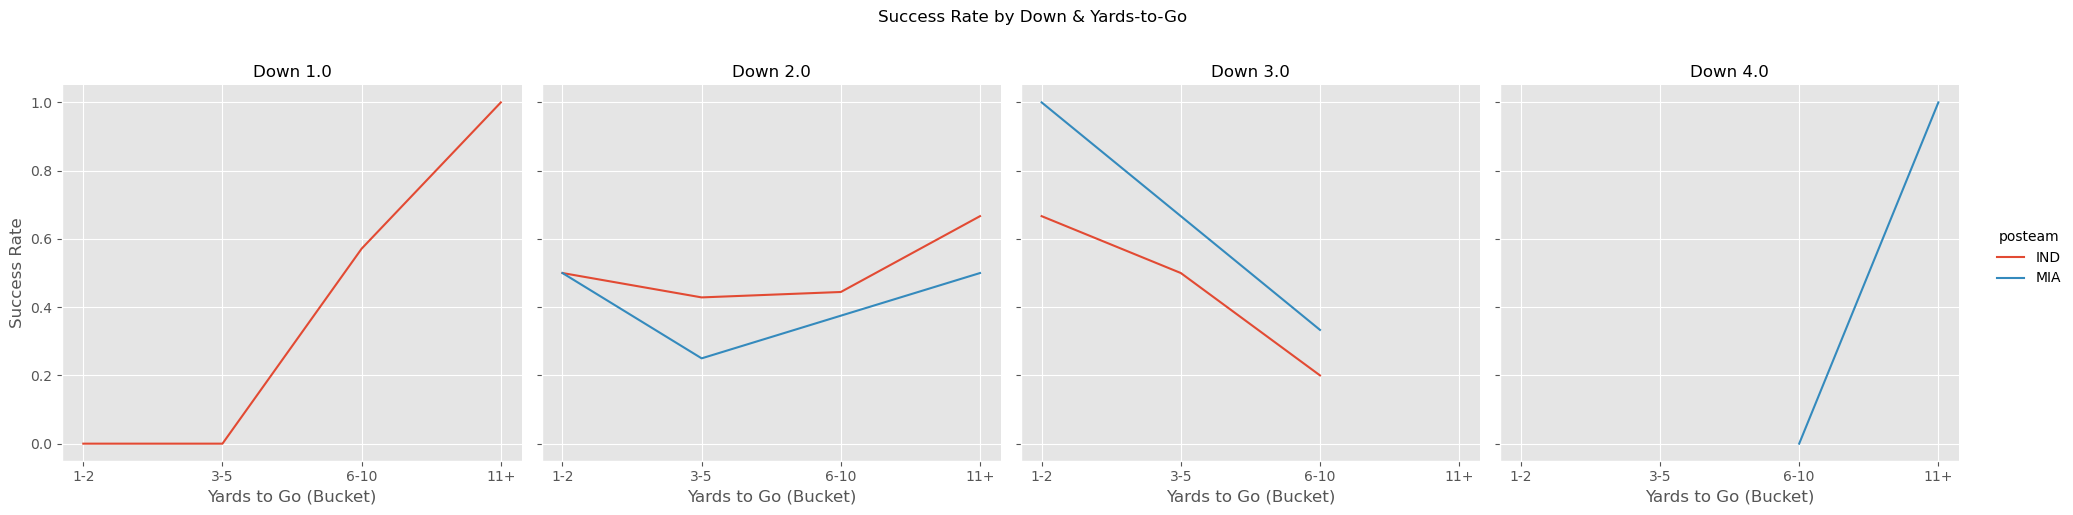

In [ ]:
pbp_g1['ytg_bucket'] = pd.cut(pbp_g1['ydstogo'], bins=[0,2,5,10,100], labels=['1-2','3-5','6-10','11+'])
pbp_g1['down_lab'] = 'Down ' + pbp_g1['down'].astype(str)

situ = pbp_g1[pbp_g1['play_type'].isin(['pass','run'])].dropna(subset=['down','ydstogo']).groupby(
    ['posteam', 'down_lab', 'ytg_bucket']
).agg(
    plays=('play_id', 'count'),
    success_rate=('success', 'mean'),
    epa_per_play=('epa', 'mean')
).reset_index()

g = sns.relplot(data=situ[situ['posteam'].isin([team, opp])], 
    x='ytg_bucket', 
    y='success_rate', 
    hue='posteam',
    col = 'down_lab',
    kind = 'line') 

g.figure.suptitle("Success Rate by Down & Yards-to-Go", y=1.02)

g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    ax.set_ylabel("Success Rate")
    ax.set_xlabel("Yards to Go (Bucket)")

g.tight_layout()

plt.show()

#### Produce a plot of EPA per play for each team in specific sections of the field

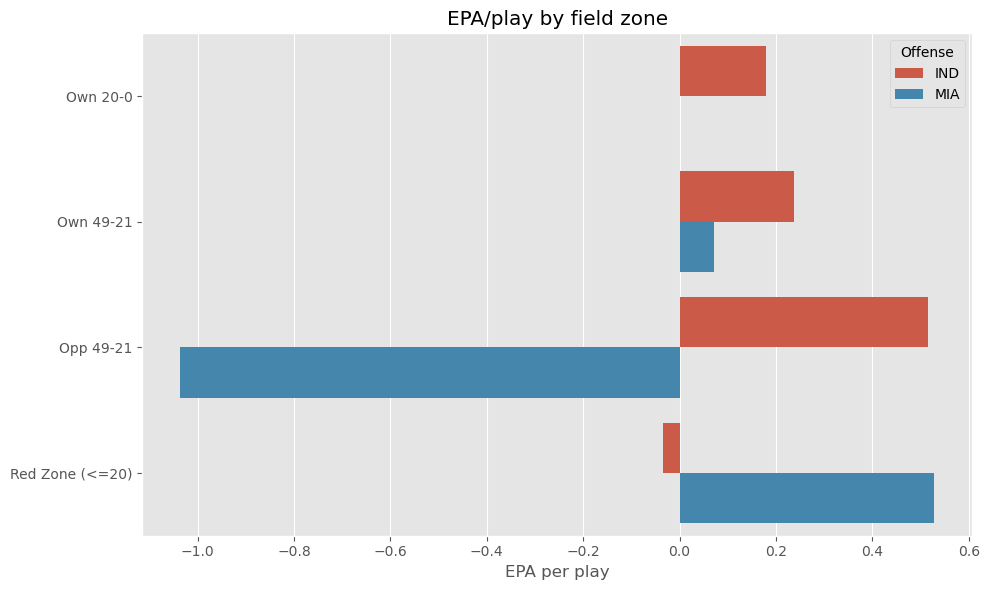

In [ ]:
fieldpos = pbp_g1[
    pbp_g1['yardline_100'].notna() &
    pbp_g1['play_type'].isin(["run", "pass"])
].copy()

fieldpos['field_zone'] = np.select(
    [
        fieldpos['yardline_100'] >= 80,
        fieldpos['yardline_100'] >= 50,
        fieldpos['yardline_100'] >= 21
    ],
    ["Own 20-0", "Own 49-21", "Opp 49-21"],
    default="Red Zone (<=20)"
)

fieldpos = fieldpos.groupby(['posteam', 'field_zone']).agg(
    plays=('play_id', 'count'),
    epa_per_play=('epa', 'mean'),
    success_rate=('success', 'mean')
).reset_index()

# Reorder the field_zone for plotting
zone_order = ["Own 20-0", "Own 49-21", "Opp 49-21", "Red Zone (<=20)"]
fieldpos['field_zone'] = pd.Categorical(fieldpos['field_zone'], categories=zone_order, ordered=True)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=fieldpos[fieldpos['posteam'].isin(["IND", opp])],
    x='epa_per_play',
    y='field_zone',
    hue='posteam',
    ax=ax,
    orient='h'
)
ax.set_title("EPA/play by field zone")
ax.set_xlabel("EPA per play")
ax.set_ylabel("")
ax.legend(title="Offense")
plt.tight_layout()
plt.show()

#### Produce a table of various stats on scoring plays

In [ ]:
drive_sum = pbp_g1[
    pbp_g1['drive'].notna() &
    pbp_g1['posteam'].notna()
].groupby(['posteam', 'drive']).agg(
    plays=('play_id', 'count'),
    yards=('yards_gained', lambda x: x.sum(skipna=True)),
    points=('points_scored', lambda x: x.sum(skipna=True)),
    epa=('epa', lambda x: x.sum(skipna=True)),
    success_rate=('success', 'mean'),
    ended_score=('touchdown', lambda x: (x.max() == 1) | ((pbp_g1.loc[x.index, 'field_goal_result'] == "made").any()) | ((pbp_g1.loc[x.index, 'safety'] == 1).max()))
).reset_index()
drive_sum = drive_sum.sort_values(by=['posteam', 'points', 'yards'], ascending=[True, False, False])

print("\n--- DRIVE SUMMARY ---\n")
print(drive_sum.head())


--- DRIVE SUMMARY ---

  posteam  drive  plays  yards  points       epa  success_rate  ended_score
1     IND    3.0     16   84.0       7  6.158075      0.625000         True
5     IND   11.0     19   84.0       7  5.212348      0.578947         True
2     IND    5.0      6   42.0       7  3.760246      0.666667         True
3     IND    7.0     18   67.0       3  2.615880      0.388889         True
0     IND    1.0     10   62.0       3  1.407006      0.600000         True


#### Produce a plot of total receiver EPA against targets

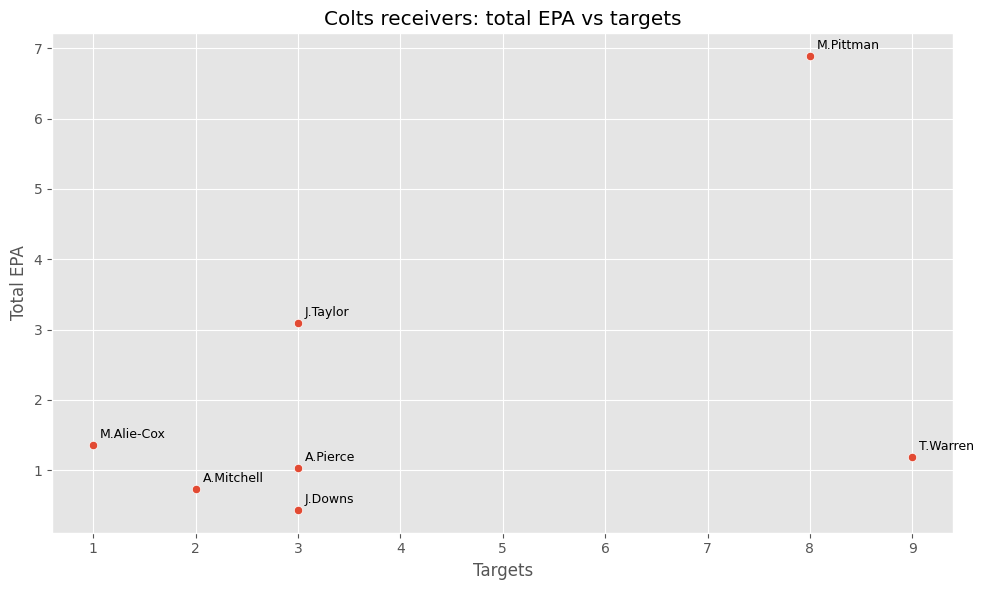

In [ ]:
colts_targets = pbp_g1[
    (pbp_g1['posteam'] == team) &
    (pbp_g1['pass'] == 1)
]['receiver_player_name'].value_counts().reset_index()
colts_targets.columns = ['receiver_player_name', 'targets']

colts_rushers = pbp_g1[
    (pbp_g1['posteam'] == team) &
    (pbp_g1['rush'] == 1)
]['rusher_player_name'].value_counts().reset_index()
colts_rushers.columns = ['rusher_player_name', 'rush_att']

epa_by_receiver = pbp_g1[
    (pbp_g1['posteam'] == team) &
    (pbp_g1['pass'] == 1) &
    pbp_g1['receiver_player_name'].notna()
].groupby('receiver_player_name').agg(
    targets=('play_id', 'count'),
    epa_sum=('epa', 'sum'),
    epa_mean=('epa', 'mean')
).reset_index()
epa_by_receiver = epa_by_receiver.sort_values(by='epa_sum', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    data=epa_by_receiver,
    x='targets',
    y='epa_sum',
    ax=ax
)

# Using ggrepel equivalent for labels
for _, row in epa_by_receiver.iterrows():
    ax.annotate(
        row['receiver_player_name'],
        (row['targets'], row['epa_sum']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9
    )

ax.set_title("Colts receivers: total EPA vs targets")
ax.set_xlabel("Targets")
ax.set_ylabel("Total EPA")
plt.tight_layout()
plt.show()

#### Produce various penalty and special teams plots

In [ ]:
penalties = pbp_g1[pbp_g1['penalty'].notna()].copy()
penalties['off_def'] = np.where(penalties['penalty_team'] == penalties['posteam'], "Offense", "Defense")
penalties_count = penalties.groupby(['penalty_team', 'off_def', 'penalty_type']).size().reset_index(name='count')
penalties_count = penalties_count.sort_values(by='count', ascending=False)
print("\n--- PENALTIES ---\n")
print(penalties_count)

st_fg = pbp_g1[pbp_g1['play_type'] == "field_goal"].groupby(['posteam', 'field_goal_result']).size().reset_index(name='count')
st_punt = pbp_g1[pbp_g1['play_type'] == "punt"].agg(
    punts=('play_id', 'count'),
    avg_punt_yards=('yards_gained', 'mean')
).T
print("\n--- SPECIAL TEAMS ---\n")
print("Field Goals:")
print(st_fg)
print("\nPunts:")
print(st_punt)


--- PENALTIES ---

  penalty_team  off_def                     penalty_type  count
1          IND  Offense                Offensive Holding      3
0          IND  Defense            Unnecessary Roughness      1
2          MIA  Defense                Defensive Holding      1
3          MIA  Defense          Running Into the Kicker      1
4          MIA  Offense  Offensive Too Many Men on Field      1

--- SPECIAL TEAMS ---

Field Goals:
  posteam field_goal_result  count
0     IND              made      4

Punts:
              punts  avg_punt_yards
play_id         1.0             NaN
yards_gained    NaN             0.0


#### Produce a plot of EPA per play by quarter for each team

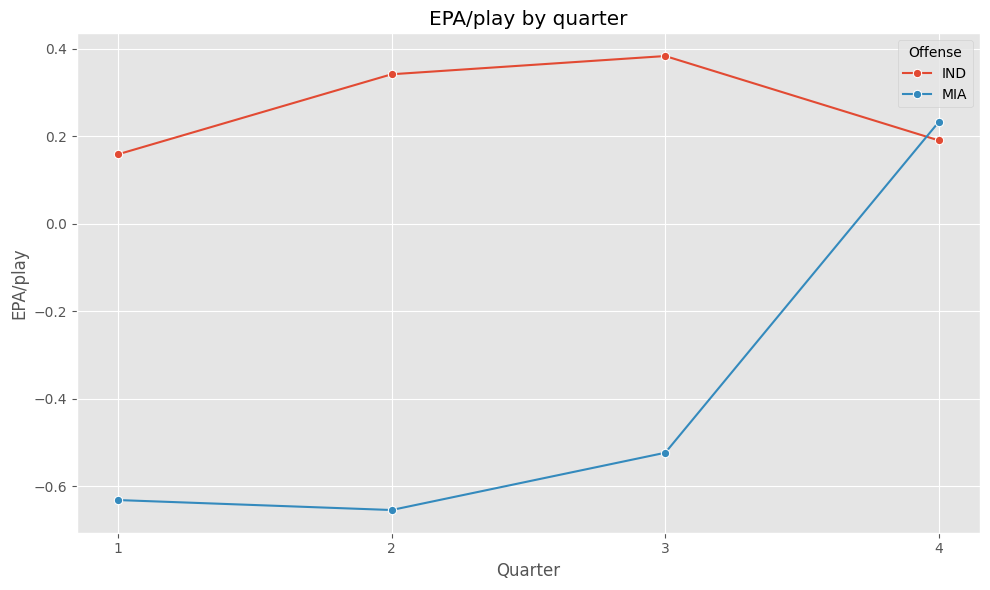

In [ ]:
epa_by_q = pbp_g1[
    pbp_g1['qtr'].isin(range(1, 5)) &
    pbp_g1['play_type'].isin(["pass", "run"])
].groupby(['posteam', 'qtr']).agg(
    epa_per_play=('epa', 'mean'),
    success_rate=('success', 'mean')
).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=epa_by_q,
    x='qtr',
    y='epa_per_play',
    hue='posteam',
    marker='o',
    ax=ax
)
ax.set_title("EPA/play by quarter")
ax.set_xlabel("Quarter")
ax.set_ylabel("EPA/play")
ax.legend(title="Offense")
ax.set_xticks(range(1, 5))
plt.tight_layout()
plt.show()

#### Produce a plot of the Colts' 10-play rolling pass completion rate

C:\Users\joshg\AppData\Local\Temp\ipykernel_111812\451942273.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])


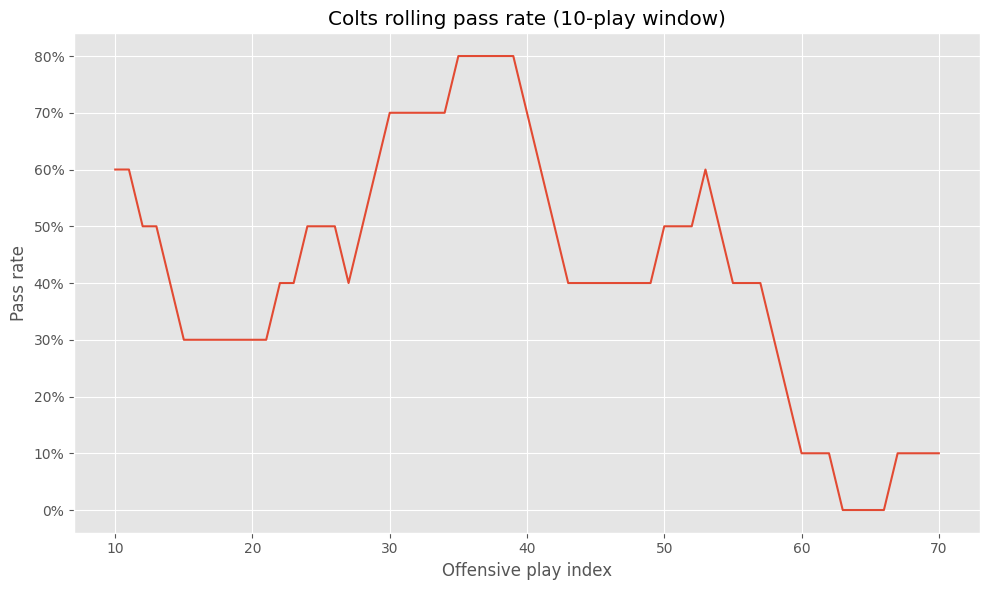

In [ ]:
colts_seq = pbp_g1[
    (pbp_g1['posteam'] == team) &
    pbp_g1['play_type'].isin(["pass", "run"])
].copy()
colts_seq = colts_seq.reset_index(drop=True)
colts_seq['play_index'] = colts_seq.index + 1
colts_seq['pass_flag'] = np.where(colts_seq['play_type'] == 'pass', 1, 0)

if len(colts_seq) >= 10:
    colts_seq['pass_rate_10'] = colts_seq['pass_flag'].rolling(window=10).mean()
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(
        data=colts_seq,
        x='play_index',
        y='pass_rate_10',
        ax=ax
    )
    ax.set_title("Colts rolling pass rate (10-play window)")
    ax.set_xlabel("Offensive play index")
    ax.set_ylabel("Pass rate")
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    plt.tight_layout()
    plt.show()

#### Produce a game summary

In [ ]:
colts_off = pbp_g1[pbp_g1['posteam'] == team]

# Perform a single aggregation to get a Series
summary_stats = pd.Series({
    'plays': colts_off['play_id'].count(),
    'pass_plays': (colts_off['play_type'] == 'pass').sum(),
    'rush_plays': (colts_off['play_type'] == 'run').sum(),
    'total_epa': colts_off['epa'].sum(),
    'mean_epa': colts_off['epa'].mean(),
    'success_rate': colts_off['success'].mean()
})

# Convert the Series to a DataFrame and transpose it
colts_off_summary = summary_stats.to_frame().T

plays_by_team_type = pbp_g1[pbp_g1['posteam'].notna()].groupby(['posteam', 'play_type']).size().reset_index(name='count')
plays_by_team_type = plays_by_team_type.sort_values(by='count', ascending=False)

print("\n--- SUMMARY ---\n")
print(f"pbp_rows: {pbp_g1.shape[0]}")
print(f"roster_rows: {rw_g1.shape[0]}")
print(f"officials_rows: {officials_g1.shape[0]}")
print("\nTempo (sec/play):")
print(tempo)
print("\nPlays by Team & Type:")
print(plays_by_team_type)
print("\nColts Offensive Summary:")
print(colts_off_summary)


--- SUMMARY ---

pbp_rows: 152
roster_rows: 201
officials_rows: 0

Tempo (sec/play):
  posteam  sec_per_play
0     IND          38.5
1     MIA          34.5

Plays by Team & Type:
   posteam    play_type  count
5      IND          run     40
8      MIA         pass     35
4      IND         pass     30
10     MIA          run     12
6      MIA      kickoff      7
1      IND   field_goal      4
3      IND      no_play      4
0      IND  extra_point      3
2      IND      kickoff      2
7      MIA      no_play      1
9      MIA         punt      1

Colts Offensive Summary:
   plays  pass_plays  rush_plays  total_epa  mean_epa  success_rate
0   85.0        30.0        40.0  21.367863  0.251387      0.552941
